In [ ]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

DATA_PATH = os.getenv('TEACHER_DIR', os.getcwd()) + '/JHL_data'

Introducing Convolution! What is it?

Before, we built a network that accepts the normalized pixel values of each value and operates soley on those values. What if we could instead feed different features (e.g. curvature, edges) of each image into a network, and have the network learn which features are important for classifying an image?

This possible through convolution! Convolution applies kernels (filters) that traverse through each image and generate feature maps, see:
https://miro.medium.com/max/500/1*GcI7G-JLAQiEoCON7xFbhg.gif

In the above example, the image is a 5 x 5 matrix and the kernel going over it is a 3 x 3 matrix. A dot product operation takes place between the image and the kernel and the convolved feature is generated. Each kernel in a CNN learns a different characteristic of an image.

Kernels are often used in photoediting software to apply blurring, edge detection, sharpening, etc.
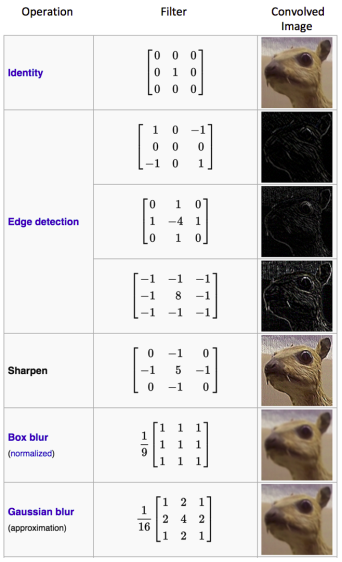


Kernels in deep learning networks are used in similar ways, i.e. highlighting some feature. Combined with a system called max pooling, the non-highlighted elements are discarded from each feature map, leaving only the features of interest, reducing the number of learned parameters, and decreasing the computational cost (e.g. system memory). 
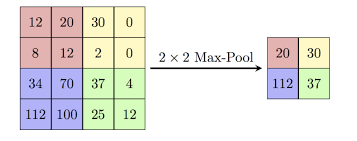


We can also take convolutions of convolutions -- we can stack as many convolutions as we want, as long as there are enough pixels to fit a kernel.

Warning: What you may find down there in those deep convolutions may not appear recognizable to you.
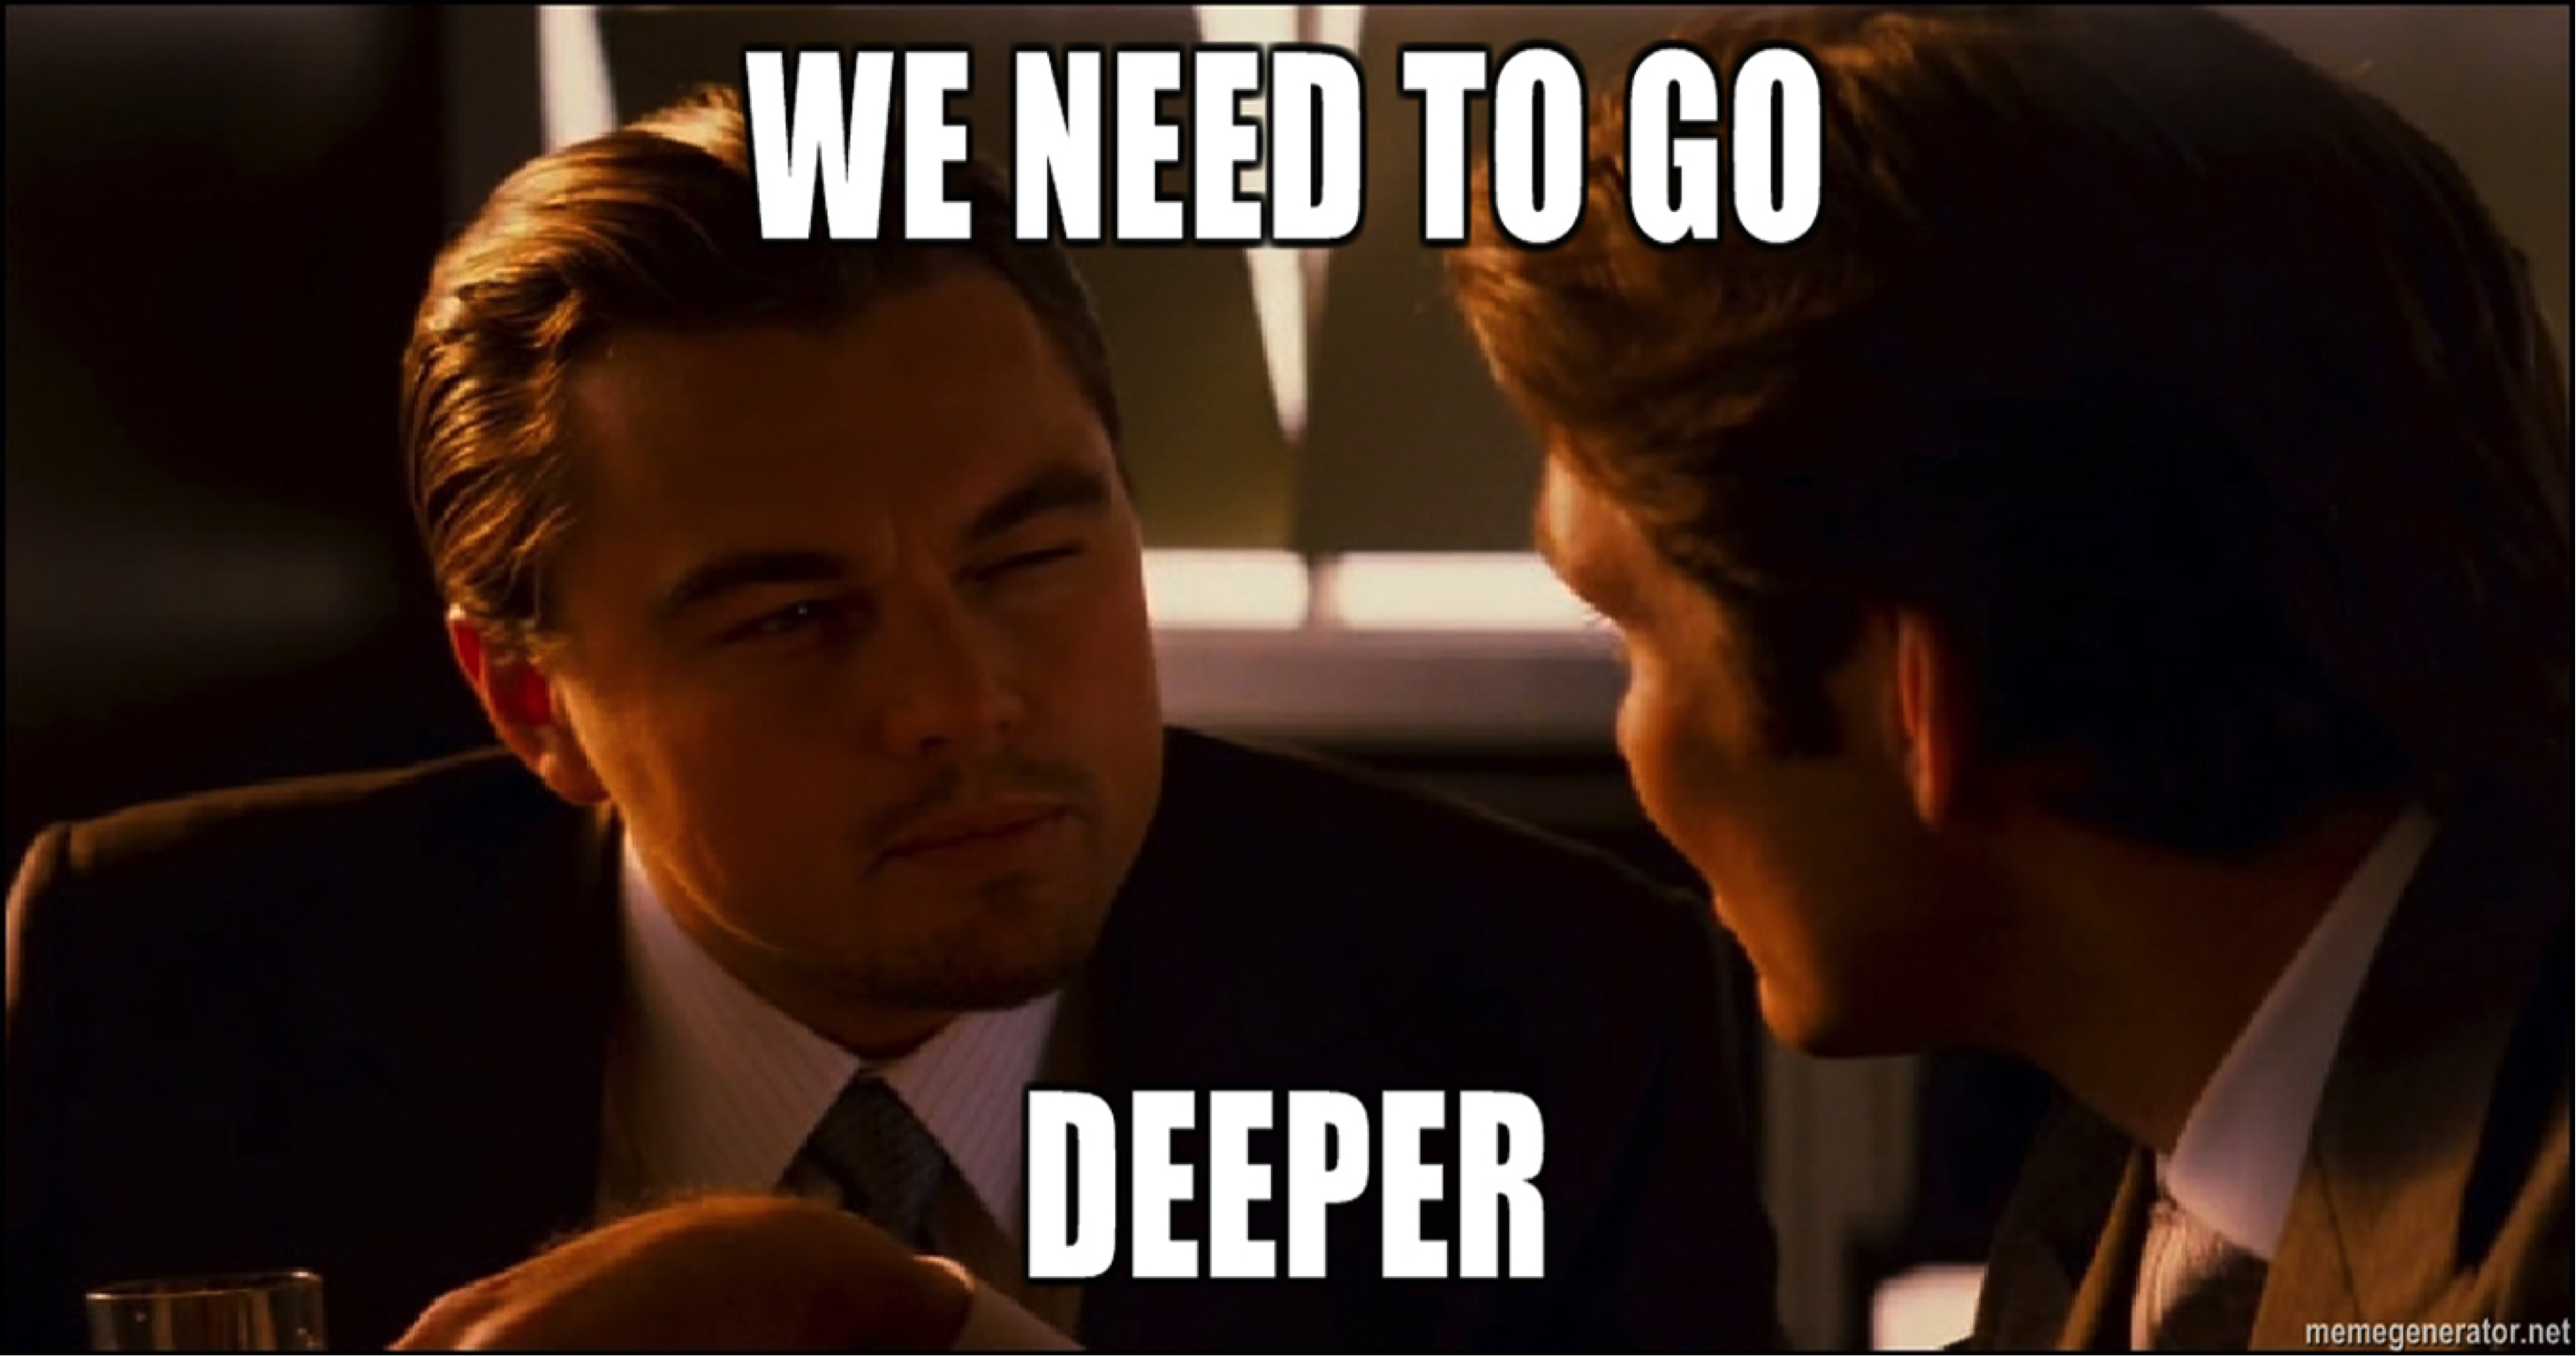


# Building the model
Let's build a model with 3 convolutional layers, and two fully connected layers. 

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        
        # conv: 1x28x28 -> 32x26x26
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1) # insert parameters here
        # relu
        self.relu1 = nn.ReLU()
        
        # --- Fill in the rest! ---
        # conv: 32x26x26 -> 64x24x24
        self.conv2 = ...
        # relu
        # max_pool: 64x24x24 -> 64x12x12
        # flatten: 64x12x12 -> 9216
        # linear: 9216 -> 128
        # relu
        # linear: 128 -> 10
        # log_softmax

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        
        # --- Fill in the rest! ---
        x = ...
        return x

### Insert your train loop that you created for the MLP here

In [ ]:
def train(model, device, train_loader, optimizer, epoch, log_interval=10):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        # set optimizer gradients to zero
        # call model to get predictions
        output = ...
        # calculate loss (hint: F.nll_loss)
        loss = ...
        # backprop loss
        # optimizer step

        if batch_idx % log_interval == 0:
            pred = output.argmax(dim=1, keepdim=True) 
            correct = pred.eq(target.view_as(pred)).sum().item()
            
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy: {:.2f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(),
                correct/len(data)
            ))

### We provide the test loop

In [ ]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            
            # get model output
            output = model(data)
            
            # calculate loss
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            
            # get most likely class label
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            
            # count the number of correct predictions
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100 * correct / len(test_loader.dataset)))


### Training hyperparameters and PyTorch boilerplate

In [ ]:
use_cuda = torch.cuda.is_available()
print(f"CUDA is {'' if use_cuda else 'not '}available")
device = torch.device("cuda" if use_cuda else "cpu")

In [ ]:
BATCH_SIZE = ...
EPOCHS = ...
LEARNING_RATE = ...
LOG_INTERVAL = 10

model = CNN().to(device)
optimizer = ... # optim.<OPTIMIZER_FLAVOUR>(model.parameters(), lr=LEARNING_RATE)


transform = transforms.Compose([
    transforms.ToTensor(), # Creates the PyTorch tensors from the PIL images, and normalizes them to the [0, 1] interval 
    transforms.Normalize((0.1307,), (0.3081,))  # Normalizes the data to 0 mean and 1 standard deviation
])


train_loader, test_loader = (
    torch.utils.data.DataLoader(
        datasets.MNIST(DATA_PATH, train=train, transform=transform, download=True),
        batch_size=BATCH_SIZE,
        pin_memory=True,
        shuffle=train
    )
    for train in (True, False)
)

for epoch in range(EPOCHS):
    train(model, device, train_loader, optimizer, epoch, LOG_INTERVAL)
    test(model, device, test_loader)

### Do you notice something when comparing the training and validation losses?
- Is there something we can do about this?



# CIFAR10

MNIST is the easiest widely-used dataset as a computer vision toy-problem.
One step above MNIST is CIFAR10, which contains images from 10 classes of objects:

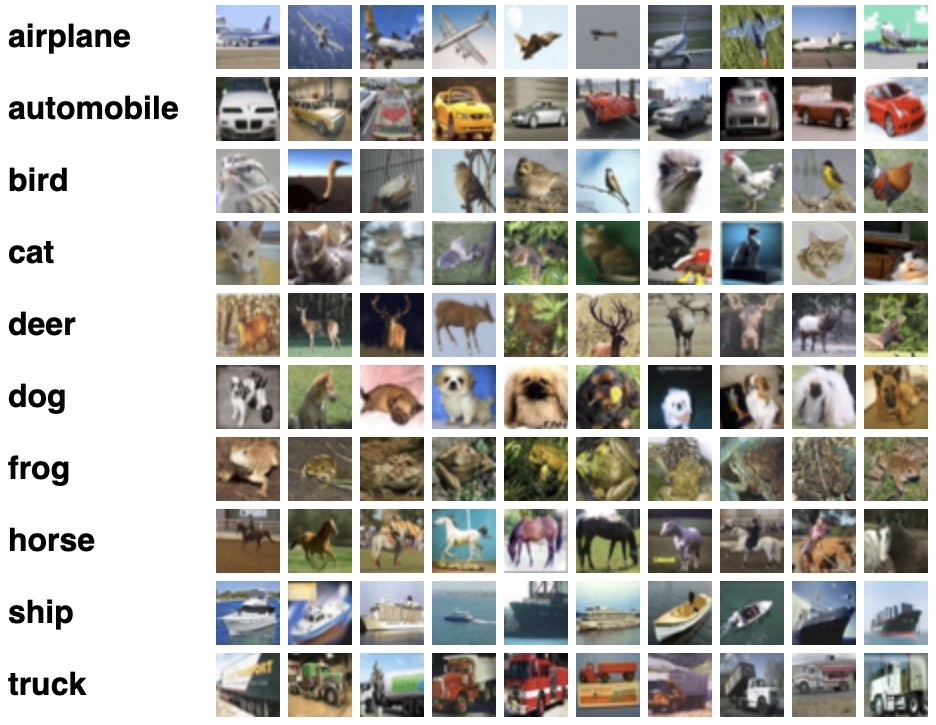

In [ ]:
class CIFAR10CNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        # 4 convolution layers, each followed by _batch-normalization_
        # (try to find out what this is and why!), and a non-linearity
        # maxpooling after the activations of the 2nd, 3rd, and 4th conv layers
        # 2 dense layers for classification
        # log_softmax
        
        self.conv1 = ...
        
        # to avoid having to init and call self.<layer> for each layer, you can also make a sequence out of them:
        # self.layers = nn.Sequential([
        #     nn.Conv2d(...),
        #     nn.ReLU(),
        #     ...
        # ])
        

    def forward(self, x):
        # --- Fill in the rest! ---
        x = ...
        return x

In [ ]:
# We can Re-use our train and test loops

BATCH_SIZE = ...
EPOCHS = ...
LEARNING_RATE = ...
LOG_INTERVAL = 10

model = CIFAR10CNN().to(device)
optimizer = ... # optim.<OPTIMIZER_FLAVOUR>(model.parameters(), lr=LEARNING_RATE)


transform=transforms.Compose([
    transforms.ToTensor(),
    # Normalize the data to 0 mean and 1 standard deviation, now for all channels of RGB
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])


train_loader, test_loader = (
    torch.utils.data.DataLoader(
        datasets.CIFAR10(DATA_PATH, train=train, transform=transform, download=True),
        batch_size=BATCH_SIZE,
        pin_memory=True,
        shuffle=train
    )
    for train in (True, False)
)

for epoch in range(EPOCHS):
    train(model, device, train_loader, optimizer, epoch, LOG_INTERVAL)
    test(model, device, test_loader)